In [ ]:
import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.applications import EfficientNetB0 # trenowany na imagenet
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.datasets import cifar100
from keras.utils import to_categorical
import imgaug as igm
import imgaug.augmenters as iaa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

In [ ]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(50000, 1)
(8000, 1)
(2000, 1)


In [ ]:
y_train = to_categorical(y_train).reshape(50000,100)
y_val = to_categorical(y_val).reshape(8000,100)
y_test = to_categorical(y_test).reshape(2000,100)

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Odbicie lustrzane wzdłuż osi pionowej
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Rozmycie gaussowskie
    iaa.Affine(rotate=(-10, 10))  # Obrót
])

In [ ]:
X_train_augmented = seq.augment_images(X_train)

In [ ]:
y_train_augmented = np.copy(y_train)

In [ ]:
# for i in range(X_train.shape[0], X_train_augmented.shape[0]):
#       y_train_augmented = np.concatenate((y_train_augmented, y_train[i % X_train.shape[0]].reshape(1, -1)))

In [ ]:
X_train = np.concatenate((X_train, X_train_augmented), axis=0)
y_train = np.concatenate((y_train, y_train_augmented), axis=0)

In [ ]:
model = Sequential(
    [
        # część konwolucyjna
        Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # część "klasyczna"
        Flatten(),
        Dense(128, activation='relu'),
        Dense(100, activation='softmax')
    ]
)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['AUC','accuracy', f1])

In [ ]:
history = model.fit(X_train, y_train, batch_size=512, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
196/196 [==============================] - 5s 13ms/step - loss: 4.2239 - auc: 0.7034 - accuracy: 0.0594 - f1: 4.7817e-04 - val_loss: 3.8682 - val_auc: 0.8014 - val_accuracy: 0.1211 - val_f1: 0.0021
Epoch 2/25
196/196 [==============================] - 2s 10ms/step - loss: 3.7157 - auc: 0.8192 - accuracy: 0.1396 - f1: 0.0143 - val_loss: 3.6096 - val_auc: 0.8374 - val_accuracy: 0.1669 - val_f1: 0.0118
Epoch 3/25
196/196 [==============================] - 2s 10ms/step - loss: 3.5480 - auc: 0.8409 - accuracy: 0.1683 - f1: 0.0261 - val_loss: 3.4606 - val_auc: 0.8545 - val_accuracy: 0.1904 - val_f1: 0.0208
Epoch 4/25
196/196 [==============================] - 2s 10ms/step - loss: 3.4391 - auc: 0.8535 - accuracy: 0.1865 - f1: 0.0348 - val_loss: 3.3685 - val_auc: 0.8647 - val_accuracy: 0.2041 - val_f1: 0.0292
Epoch 5/25
196/196 [==============================] - 2s 12ms/step - loss: 3.3477 - auc: 0.8627 - accuracy: 0.2042 - f1: 0.0445 - val_loss: 3.2947 - val_auc: 0.8701 - val_accur

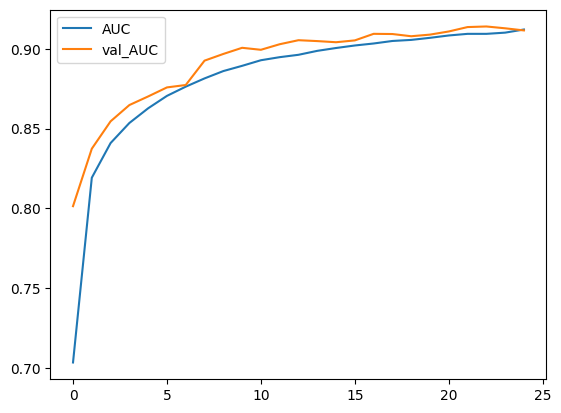

In [ ]:
plt.plot(history.epoch, history.history['auc'], label = 'AUC')
plt.plot(history.epoch, history.history['val_auc'], label = 'val_AUC')
plt.legend()
plt.show()

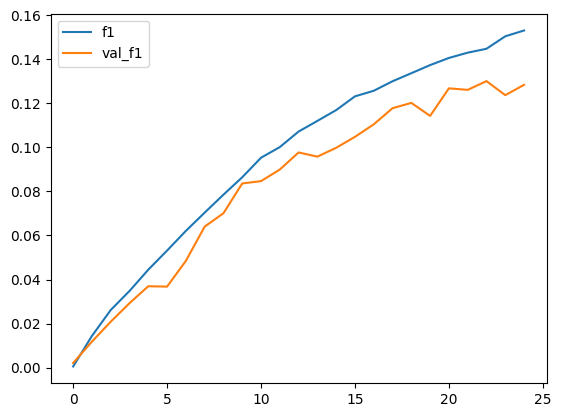

In [ ]:
plt.plot(history.epoch, history.history['f1'], label = 'f1')
plt.plot(history.epoch, history.history['val_f1'], label = 'val_f1')
plt.legend()
plt.show()